In [ ]:
# Install / Imports
!pip -q install datasets scikit-learn

import re
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Reproducibility + Device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# SNIPS load dataset and intent classification
ds = load_dataset("DeepPavlov/snips", "default")

print(ds)
print("Train size:", len(ds["train"]), "Test size:", len(ds["test"]))
print("Example:", ds["train"][0])



DatasetDict({
    train: Dataset({
        features: ['utterance', 'label'],
        num_rows: 13084
    })
    test: Dataset({
        features: ['utterance', 'label'],
        num_rows: 1400
    })
})
Train size: 13084 Test size: 1400
Example: {'utterance': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist', 'label': 0}


In [ ]:
# Text cleaning + tokenization
def clean_text(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def tokenize(s: str):
    # simple whitespace tokenization (keeps it close to "tokenize text, build vocab" requirement)
    return clean_text(s).split()

In [ ]:
# Build vocabulary
from collections import Counter

MIN_FREQ = 1          # keep 1 to avoid dropping rare words
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

counter = Counter()
for x in ds["train"]["utterance"]:
    counter.update(tokenize(x))

itos = [PAD_TOKEN, UNK_TOKEN]  # index -> token
for w, c in counter.items():
    if c >= MIN_FREQ:
        itos.append(w)

stoi = {w:i for i,w in enumerate(itos)}

pad_id = stoi[PAD_TOKEN]
unk_id = stoi[UNK_TOKEN]

print("Vocab size:", len(itos), "| pad_id:", pad_id, "| unk_id:", unk_id)


Vocab size: 11695 | pad_id: 0 | unk_id: 1


In [ ]:
#Encode sequences + choose max_len (pad/truncate)
MAX_LEN = 30

def encode(tokens):
    ids = [stoi.get(t, unk_id) for t in tokens]
    return ids

def pad_trunc(ids, max_len=MAX_LEN):
    if len(ids) >= max_len:
        return ids[:max_len], max_len
    else:
        return ids + [pad_id]*(max_len - len(ids)), len(ids)

# label info
num_classes = len(set(ds["train"]["label"]))
print("Num classes:", num_classes)


Num classes: 7


In [ ]:
# Pytorch Dataset
class SnipsDataset(Dataset):
    def __init__(self, split):
        self.texts = ds[split]["utterance"]
        self.labels = ds[split]["label"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = tokenize(self.texts[idx])
        ids = encode(tokens)
        x, length = pad_trunc(ids, MAX_LEN)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(length, dtype=torch.long), torch.tensor(y, dtype=torch.long)

train_data = SnipsDataset("train")
test_data  = SnipsDataset("test")


In [ ]:
# DataLoader (Iteration 1: no packing, simple batch)
BATCH1 = 16

def collate_basic(batch):
    xs, lens, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)        # (B, T)
    lens = torch.stack(lens, dim=0)    # (B,)
    ys = torch.stack(ys, dim=0)        # (B,)
    return xs, lens, ys

train_loader1 = DataLoader(train_data, batch_size=BATCH1, shuffle=True, collate_fn=collate_basic)
test_loader1  = DataLoader(test_data,  batch_size=BATCH1, shuffle=False, collate_fn=collate_basic)


In [ ]:
# Model (Iteration 1)
class RNNClassifierBasic(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, pad_id):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        # x: (B,T)
        emb = self.embedding(x)                # (B,T,D)
        out, h = self.rnn(emb)                 # out: (B,T,H), h: (1,B,H)

        # take last *real* timestep using lengths-1
        idx = (lengths - 1).clamp(min=0)       # (B,)
        idx = idx.view(-1, 1, 1).expand(-1, 1, out.size(2))  # (B,1,H)
        last = out.gather(1, idx).squeeze(1)   # (B,H)

        logits = self.fc(last)                 # (B,C)
        return logits

model1 = RNNClassifierBasic(len(itos), emb_dim=64, hidden_dim=64, num_classes=num_classes, pad_id=pad_id).to(device)
print(model1)


RNNClassifierBasic(
  (embedding): Embedding(11695, 64, padding_idx=0)
  (rnn): RNN(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)


In [ ]:
# Train / Eval loops + History
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch_basic(model, loader, optimizer, criterion):
    model.train()
    losses, accs = [], []
    for x, lengths, y in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits, y))

    return float(np.mean(losses)), float(np.mean(accs))

@torch.no_grad()
def eval_one_epoch_basic(model, loader, criterion):
    model.eval()
    losses, accs = [], []
    all_true, all_pred = [], []
    for x, lengths, y in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        logits = model(x, lengths)
        loss = criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        losses.append(loss.item())
        accs.append((preds == y).float().mean().item())

        all_true.extend(y.cpu().numpy().tolist())
        all_pred.extend(preds.cpu().numpy().tolist())

    return float(np.mean(losses)), float(np.mean(accs)), all_true, all_pred

def plot_history(hist, title):
    epochs = list(range(1, len(hist["train_loss"]) + 1))

    plt.figure()
    plt.plot(epochs, hist["train_loss"], label="train loss")
    plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, hist["train_acc"], label="train acc")
    plt.plot(epochs, hist["val_acc"], label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.show()


Epoch 01 | train loss 0.5791 acc 0.8174 | val loss 0.2722 acc 0.9183
Epoch 02 | train loss 0.1701 acc 0.9495 | val loss 0.1822 acc 0.9439
Epoch 03 | train loss 0.1023 acc 0.9704 | val loss 0.1341 acc 0.9631
Epoch 04 | train loss 0.0695 acc 0.9801 | val loss 0.1321 acc 0.9638
Epoch 05 | train loss 0.0575 acc 0.9827 | val loss 0.1283 acc 0.9680
Epoch 06 | train loss 0.0338 acc 0.9907 | val loss 0.1476 acc 0.9616


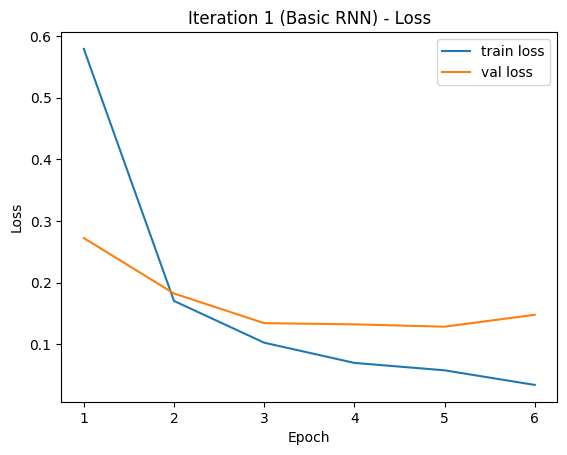

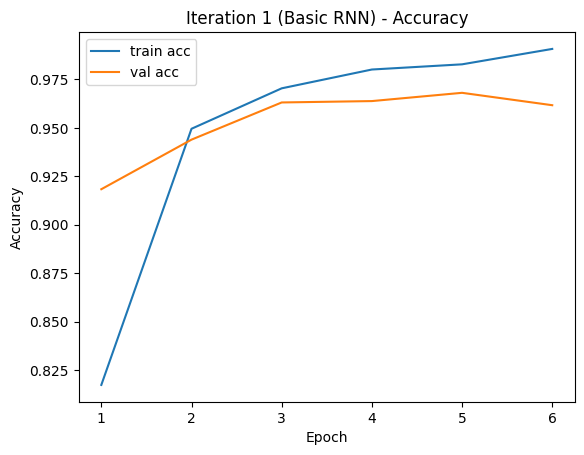

In [ ]:
# Train Iteration 1
EPOCHS1 = 6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

history1 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS1 + 1):
    tr_loss, tr_acc = train_one_epoch_basic(model1, train_loader1, optimizer, criterion)
    va_loss, va_acc, _, _ = eval_one_epoch_basic(model1, test_loader1, criterion)

    history1["train_loss"].append(tr_loss)
    history1["train_acc"].append(tr_acc)
    history1["val_loss"].append(va_loss)
    history1["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

plot_history(history1, "Iteration 1 (Basic RNN)")


In [ ]:
# Iteration 2 Pad+Pack collate
def pad_and_pack(batch):
    xs, lens, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)           # already padded to MAX_LEN
    lens = torch.stack(lens, dim=0)
    ys = torch.stack(ys, dim=0)

    # sort by length (optional, but good practice)
    lens_sorted, sort_idx = torch.sort(lens, descending=True)
    xs_sorted = xs[sort_idx]
    ys_sorted = ys[sort_idx]

    return xs_sorted, lens_sorted, ys_sorted, sort_idx

BATCH2 = 32
train_loader2 = DataLoader(train_data, batch_size=BATCH2, shuffle=True, collate_fn=pad_and_pack)
test_loader2  = DataLoader(test_data,  batch_size=BATCH2, shuffle=False, collate_fn=pad_and_pack)


In [ ]:
# Model with packing
class RNNClassifierPacked(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, pad_id, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        emb = self.embedding(x)  # (B,T,D)

        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=True
        )
        packed_out, h = self.rnn(packed)

        # h: (num_layers, B, H) -> use last layer hidden
        last_h = h[-1]  # (B,H)
        logits = self.fc(last_h)
        return logits

model2 = RNNClassifierPacked(len(itos), emb_dim=128, hidden_dim=128, num_classes=num_classes, pad_id=pad_id,
                             num_layers=2, dropout=0.2).to(device)
print(model2)


RNNClassifierPacked(
  (embedding): Embedding(11695, 128, padding_idx=0)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:
# Train/Eval loops for packed loaders
def train_one_epoch_packed(model, loader, optimizer, criterion):
    model.train()
    losses, accs = [], []
    for x, lengths, y, _sort_idx in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits, y))
    return float(np.mean(losses)), float(np.mean(accs))

@torch.no_grad()
def eval_one_epoch_packed(model, loader, criterion):
    model.eval()
    losses, accs = [], []
    all_true, all_pred, all_text = [], [], []

    for x, lengths, y, sort_idx in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        logits = model(x, lengths)
        loss = criterion(logits, y)

        preds = torch.argmax(logits, dim=1)

        losses.append(loss.item())
        accs.append((preds == y).float().mean().item())

        all_true.extend(y.cpu().numpy().tolist())
        all_pred.extend(preds.cpu().numpy().tolist())

    return float(np.mean(losses)), float(np.mean(accs)), all_true, all_pred


Epoch 01 | train loss 0.4334 acc 0.8602 | val loss 0.2028 acc 0.9396 | best 0.9396
Epoch 02 | train loss 0.1307 acc 0.9600 | val loss 0.1792 acc 0.9489 | best 0.9489
Epoch 03 | train loss 0.1080 acc 0.9671 | val loss 0.1172 acc 0.9643 | best 0.9643
Epoch 04 | train loss 0.0520 acc 0.9853 | val loss 0.1055 acc 0.9730 | best 0.9730
Epoch 05 | train loss 0.0363 acc 0.9898 | val loss 0.1071 acc 0.9735 | best 0.9735
Epoch 06 | train loss 0.0274 acc 0.9920 | val loss 0.1087 acc 0.9714 | best 0.9735
Epoch 07 | train loss 0.0176 acc 0.9950 | val loss 0.1073 acc 0.9721 | best 0.9735
Epoch 08 | train loss 0.0147 acc 0.9960 | val loss 0.1063 acc 0.9749 | best 0.9749
Epoch 09 | train loss 0.0114 acc 0.9975 | val loss 0.1176 acc 0.9742 | best 0.9749
Epoch 10 | train loss 0.0091 acc 0.9980 | val loss 0.1145 acc 0.9763 | best 0.9763


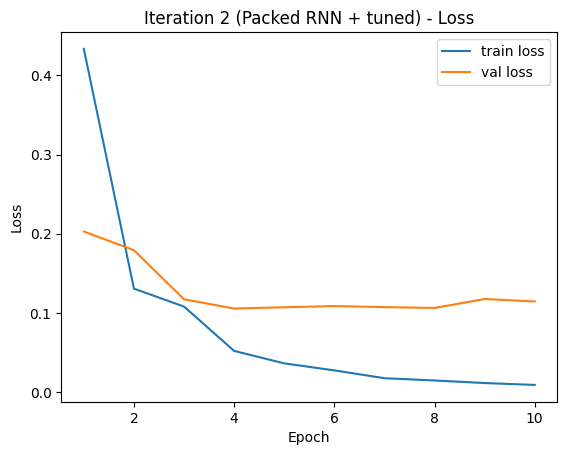

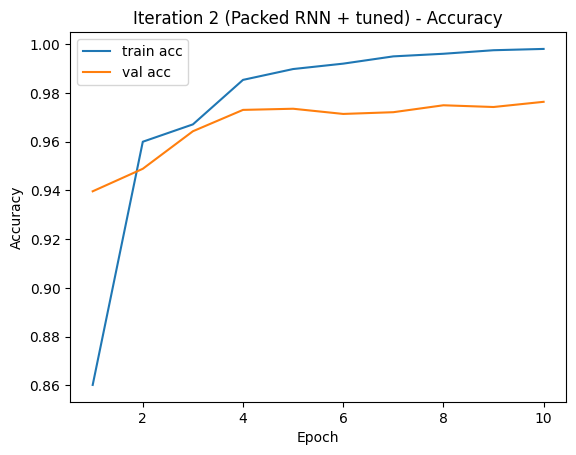

In [ ]:
# Train Iteration 2 + curves
EPOCHS2 = 10
criterion2 = nn.CrossEntropyLoss()

optimizer2 = torch.optim.Adam(model2.parameters(), lr=8e-4, weight_decay=1e-5)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=3, gamma=0.5)

history2 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_acc = -1
best_state = None

for epoch in range(1, EPOCHS2 + 1):
    tr_loss, tr_acc = train_one_epoch_packed(model2, train_loader2, optimizer2, criterion2)
    va_loss, va_acc, _, _ = eval_one_epoch_packed(model2, test_loader2, criterion2)

    history2["train_loss"].append(tr_loss)
    history2["train_acc"].append(tr_acc)
    history2["val_loss"].append(va_loss)
    history2["val_acc"].append(va_acc)

    if va_acc > best_acc:
        best_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model2.state_dict().items()}

    scheduler2.step()

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f} | best {best_acc:.4f}")

# load best
model2.load_state_dict({k: v.to(device) for k, v in best_state.items()})
plot_history(history2, "Iteration 2 (Packed RNN + tuned)")


Label names not available; using numeric labels.

Final Accuracy: 0.9764285714285714

Classification Report:

              precision    recall  f1-score   support

           0     0.9803    0.9950    0.9876       200
           1     0.9852    1.0000    0.9926       200
           2     0.9798    0.9700    0.9749       200
           3     0.9703    0.9800    0.9751       200
           4     0.9950    0.9950    0.9950       200
           5     0.9588    0.9300    0.9442       200
           6     0.9650    0.9650    0.9650       200

    accuracy                         0.9764      1400
   macro avg     0.9763    0.9764    0.9763      1400
weighted avg     0.9763    0.9764    0.9763      1400


Confusion Matrix:
 [[199   1   0   0   0   0   0]
 [  0 200   0   0   0   0   0]
 [  0   2 194   0   0   2   2]
 [  3   0   1 196   0   0   0]
 [  1   0   0   0 199   0   0]
 [  0   0   3   5   1 186   5]
 [  0   0   0   1   0   6 193]]


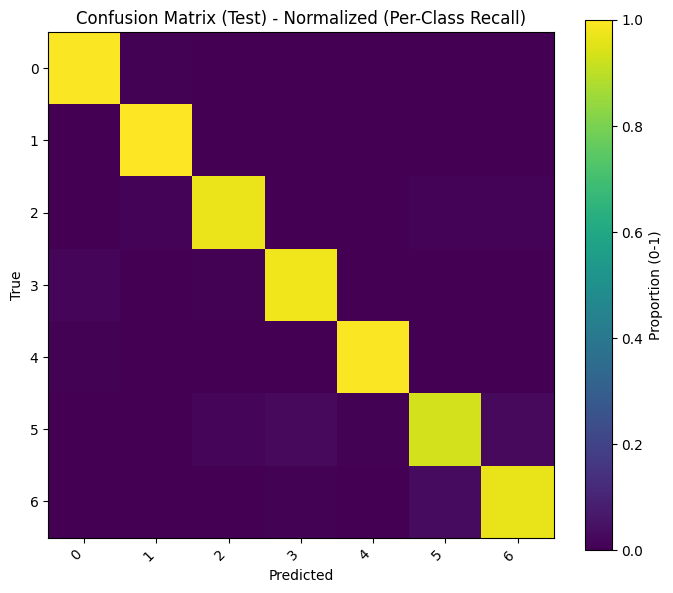


Sample misclassifications:
- True=0 (0) | Pred=1 (1) | Text: Add brian larsen to my digster sleep
- True=2 (2) | Pred=1 (1) | Text: Show weather forecast nearby Elk City State Park
- True=2 (2) | Pred=1 (1) | Text: What is the weather forecast for Yoakum , SC ?
- True=2 (2) | Pred=6 (6) | Text: What's the forecase for Inverness on February 5th, 2031 ?
- True=2 (2) | Pred=6 (6) | Text: What is the weather forecast for Burundi
- True=2 (2) | Pred=5 (5) | Text: Will there be a blizzard next winter in Visalia , Idaho
- True=2 (2) | Pred=5 (5) | Text: Play shadowplay by Dana on Deezer .
- True=3 (3) | Pred=0 (0) | Text: Please play some fourties music on Spotify
- True=3 (3) | Pred=0 (0) | Text: Play the most popular Puretone
- True=3 (3) | Pred=2 (2) | Text: Please play something on Iheart from artist Ari Gold last album


In [ ]:
# Final evaluation: report + confusion matrix + misclassifications
# Build label names if available (otherwise numeric 0..C-1)
label_names = None
try:
    if "label" in ds["train"].features and hasattr(ds["train"].features["label"], "names"):
        label_names = ds["train"].features["label"].names
except:
    pass

if label_names is None:
    label_names = [str(i) for i in range(num_classes)]
    print("Label names not available; using numeric labels.")
else:
    print("Label names:", label_names)

# Get raw test texts (same order as ds["test"])
test_texts = list(ds["test"]["utterance"])

# Predict on test set (note: we used a loader that sorts within batches, but metrics are order-independent)
_, _, y_true, y_pred = eval_one_epoch_packed(model2, test_loader2, criterion2)

print("\nFinal Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:\n", cm)

# Plot normalized confusion matrix (per-class recall)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
plt.imshow(cm_norm, vmin=0, vmax=1, interpolation="nearest")
plt.title("Confusion Matrix (Test) - Normalized (Per-Class Recall)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), label_names, rotation=45, ha="right")
plt.yticks(range(num_classes), label_names)
plt.colorbar(label="Proportion (0-1)")
plt.tight_layout()
plt.show()

# Misclassification samples (explain True vs Pred)
wrong_idx = np.where(np.array(y_true) != np.array(y_pred))[0][:10]
print("\nSample misclassifications:")
for i in wrong_idx:
    i = int(i)
    print(f"- True={y_true[i]} ({label_names[y_true[i]]}) | Pred={y_pred[i]} ({label_names[y_pred[i]]}) | Text: {test_texts[i][:120]}")


Iteration 1 – Baseline Vanilla RNN

What changed:
A baseline vanilla RNN classifier was implemented using fixed-length sequences via padding and truncation. The model consists of tokenisation, an embedding layer, a single-layer RNN, and a linear classification head that predicts one intent label from the final hidden state.

Why this design:
This iteration establishes a simple and correct baseline that is fully aligned with the module content. It follows the standard many-to-one sequence classification pipeline taught in Week 12 (RNN in PyTorch):
tokenise text → convert to embeddings → process with RNN → use the last hidden state → classify using a linear layer.
Using a vanilla RNN allows the core recurrent concept to be demonstrated without introducing more advanced architectures.

Observed results:
The training and validation curves show that the model is able to learn and converge, although convergence is relatively slower and training is less stable compared to later iterations. This behaviour is expected for a simple baseline model with limited capacity.

Iteration 2 – Improved Vanilla RNN

What changed:
Several improvements were introduced while keeping the architecture within the scope of the taught material:

Packed sequences using pack_padded_sequence to avoid unnecessary computation on padded tokens (as taught in Week 12 – RNN in PyTorch II).

Increased embedding dimension and hidden size to improve representation capacity.

Upgraded to a 2-layer vanilla RNN with dropout for better generalisation.

Hyperparameter tuning, including learning rate adjustment, weight decay, and a learning-rate scheduler.

The number of training epochs was increased to allow the higher-capacity model to converge more fully.

Why these changes help:
Packing sequences improves training efficiency and reduces the negative effect of padding on gradient updates. Increasing model capacity allows the RNN to capture more complex sequential patterns in text, while dropout helps reduce overfitting. Hyperparameter tuning further stabilises training and improves convergence.

Observed results:
Compared to Iteration 1, this model achieves higher validation accuracy with smoother and more stable training curves. The confusion matrix and misclassification analysis show that most predictions are correct, with remaining errors mainly arising from semantic overlap between intent classes.

Conclusion:
While the baseline vanilla RNN already performs well on SNIPS, the improved model with packed sequences and tuned hyperparameters achieves higher peak validation accuracy and more stable convergence.